### 9 - Does the source exhibit energy-dependent morphology? 

A dedicated estimator has been implemented to answer to this question, EnergyDependentMorphologyEstimator

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table
import matplotlib.pyplot as plt

from gammapy.maps import Map
from gammapy.datasets import MapDataset, Datasets
from gammapy.modeling.models import PowerLawSpectralModel, GaussianSpatialModel, SkyModel
from gammapy.estimators import EnergyDependentMorphologyEstimator
from gammapy.stats.utils import ts_to_sigma

In [2]:
stacked_dataset = MapDataset.read("stacked_MapDataset.fits")

datasets = Datasets([stacked_dataset])

Define the energy edges of interest. These will be utilised to investigate the potential of energy-dependent morphology in the dataset.

In [3]:
energy_edges=[0.4, 1.5, 20]*u.TeV

Define the models to fit. The start values here are taken from the fit we did previously on the entire dataset.
The `GaussianSpatialModel` allows us to test the energy-dependent morphology component in each energy band.

In [4]:
source_position = SkyCoord.from_name("RX J1713.7-3946").galactic

spectral_model = PowerLawSpectralModel(
    index=1.913, amplitude=2.3e-12 * u.Unit("cm-2 s-1 TeV-1"), reference=1.0 * u.TeV
)

spatial_model = GaussianSpatialModel(
    lon_0=source_position.l,
    lat_0=source_position.b,
    frame="galactic",
    sigma=0.2 * u.deg,
)

# Limit the search for the position on the spatial model
spatial_model.lon_0.min = source_position.galactic.l.deg - 0.8
spatial_model.lon_0.max = source_position.galactic.l.deg + 0.8
spatial_model.lat_0.min = source_position.galactic.b.deg - 0.8
spatial_model.lat_0.max = source_position.galactic.b.deg + 0.8

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name="src")

Let’s start with the initial hypothesis, in which the source is introduced to compare with the background. 

In [5]:
model.spatial_model.lon_0.frozen = False
model.spatial_model.lat_0.frozen = False
model.spatial_model.sigma.frozen = False

model.spectral_model.amplitude.frozen = False
model.spectral_model.index.frozen = True

datasets.models = model

estimator = EnergyDependentMorphologyEstimator(energy_edges=energy_edges, source="src")

## Run the estimator and view the results

In [6]:
results = estimator.run(datasets)

Lets see what that contains

In [7]:
results

{'energy_dependence': {'delta_ts': 9.749805383442435,
  'df': 3,
  'result': {'Hypothesis': ['H0', 'H1', 'H1'],
   'Emin': <Quantity [0.4, 0.4, 1.5] TeV>,
   'Emax': <Quantity [20. ,  1.5, 20. ] TeV>,
   'lon_0': <Quantity [347.25315592, 347.22020569, 347.30203464] deg>,
   'lon_0_err': <Quantity [0.01774988, 0.02303687, 0.02834814] deg>,
   'lat_0': <Quantity [-0.38502573, -0.39792979, -0.36699214] deg>,
   'lat_0_err': <Quantity [0.01693211, 0.02129856, 0.0283809 ] deg>,
   'sigma': <Quantity [0.37502957, 0.39843129, 0.34630921] deg>,
   'sigma_err': <Quantity [0.01388267, 0.01954996, 0.01972321] deg>}},
 'src_above_bkg': {'Emin': <Quantity [0.4, 1.5] TeV>,
  'Emax': <Quantity [ 1.5, 20. ] TeV>,
  'delta_ts': [716.9237949869712, 357.51635524773155],
  'df': [4, 4],
  'significance': [26.422560530191227, 18.46196892112459]}}

Can access the results for the `src_above_bkg`. These are values for each energy band for the significance of the signal above the background.

In [8]:
table_bkg_src = Table(results["src_above_bkg"])
display(table_bkg_src)

Emin,Emax,delta_ts,df,significance
TeV,TeV,,,
float64,float64,float64,int64,float64
0.4,1.5,716.9237949869712,4,26.422560530191227
1.5,20.0,357.51635524773155,4,18.46196892112459


Lets look at the desults for the energy-dependence!

In [9]:
ts = results["energy_dependence"]["delta_ts"]
df = results["energy_dependence"]["df"]
sigma = ts_to_sigma(ts, df=df)

print(f"The delta_ts for the energy-dependent study: {ts:.3f}.")
print(f"Converting this to a significance gives: {sigma:.3f} \u03C3")

results_table = Table(results["energy_dependence"]["result"])
display(results_table)

The delta_ts for the energy-dependent study: 9.750.
Converting this to a significance gives: 2.311 σ


Hypothesis,Emin,Emax,lon_0,lon_0_err,lat_0,lat_0_err,sigma,sigma_err
,TeV,TeV,deg,deg,deg,deg,deg,deg
str2,float64,float64,float64,float64,float64,float64,float64,float64
H0,0.4,20.0,347.2531559217392,0.017749881140418623,-0.3850257329094031,0.016932114262269166,0.37502956674992227,0.013882671821621098
H1,0.4,1.5,347.22020568686753,0.023036874648775813,-0.3979297940524748,0.021298558438532025,0.39843128719859716,0.01954996162573595
H1,1.5,20.0,347.302034638351,0.028348135228415054,-0.36699214170175876,0.028380899348250475,0.3463092112508961,0.019723206874745658


## Plotting those results

In [10]:
energy_result = results["energy_dependence"]["result"]
lat_0, lat_0_err = energy_result["lat_0"][1:], energy_result["lat_0_err"][1:]
lon_0, lon_0_err = energy_result["lon_0"][1:], energy_result["lon_0_err"][1:]
sigma, sigma_err = energy_result["sigma"][1:], energy_result["sigma_err"][1:]

In [11]:
model_plots = []

for i in range(len(lat_0)):
    model_plot = GaussianSpatialModel(
        lat_0=lat_0[i],
        lon_0=lon_0[i],
        sigma=sigma[i],
        frame=spatial_model.frame
    )
    model_plot.lat_0.error = lat_0_err[i]
    model_plot.lon_0.error = lon_0_err[i]
    model_plot.sigma.error = sigma_err[i]
    model_plots.append((model_plot))

/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/feijen/anaconda3/envs/gammapy-1.2-withray/lib/python3.10/site-packages/astropy/visualization/mpl_normalize.py:179: RuntimeWarning: invalid value encountered in divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


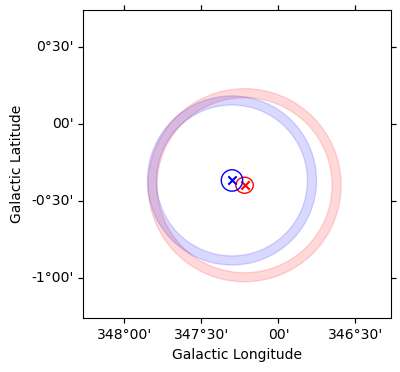

In [12]:
empty_map = Map.create(
    skydir=spatial_model.position, frame=spatial_model.frame, width=2, binsz=0.02
)

colors = ["red", "blue"]

fig = plt.figure(figsize=(6, 4))
ax = empty_map.plot()

for i, model_plot in enumerate(model_plots):
    
    model_plot.plot_error(
        ax=ax,
        which="all",
        kwargs_extension={"facecolor": colors[i], "edgecolor": colors[i]},
        kwargs_position={"color": colors[i]},
    )
plt.show()